## Constructing Knowledge Graphs from Text

In [1]:
# importing all the required packages
import spacy
from spacy.lang.en import English
from SPARQLWrapper import SPARQLWrapper, JSON
import networkx as nx
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_lg')
%matplotlib inline

### Input Cell

In [2]:
# Enter the City to construct the Knowledge Graph (ensure correct spelling)

city = 'Bangalore'

In [3]:
# This function currently retrieves ABSTRACT, POPULATION, COUNTRY and ALIASES for the city, 
# it can be extended to fetch any other information from DBpedia that is required.

def fetchData(city):
    '''
    input: string : city name
    output: dict : dictionary containing the results of city information from DBpedia
    
    This function uses SPARQL endpoint to extract information about the given city 
    from DBpedia in JSON format.
    '''
    
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    sparql.setQuery(
        """
        PREFIX dbr: <http://dbpedia.org/resource/>
        PREFIX dbo: <http://dbpedia.org/ontology/>
        PREFIX foaf: <http://xmlns.com/foaf/0.1/>

        SELECT ?name, ?city, ?abstract, ?population, ?country, ?alias, ?timezone
        WHERE {{
            ?city a dbo:City .
            ?city rdfs:label ?name .
            ?city dbo:abstract ?abstract .
            ?city dbo:populationTotal ?population .
            ?city dbo:abstract ?abstract .
            ?city dbo:country ?country .
            ?city rdfs:label {0}@en .
            ?city foaf:name ?alias .
            ?city dbo:timeZone ?timezone .
            FILTER ( langMatches(lang(?abstract),"en") ) . 
           FILTER ( langMatches(lang(?name),"en") ) .
        }}
        """.format(city)
        )

    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    return results

In [4]:
# call the fetchData function to get the results, the double quotes are necessary for the query
# which is why the double quotes are appended on either sides of the city string

results = fetchData('"' + city + '"')

In [5]:
# the results from DBpedia are stored in local variables. 'abstract' contains the raw text from
# which information is extracted to construct Knowledge Graphs

alias = []
for result in results["results"]["bindings"]:
    abstract = result["abstract"]["value"]
    population = result["population"]["value"]
    country = result["country"]["value"].replace("http://dbpedia.org/resource/",'')
    timezone = result["timezone"]["value"].replace("http://dbpedia.org/resource/",'')
    alias.append(result["alias"]["value"])

In [6]:
def getSentences(text):
    '''
    input: string : abstact text
    output : list: list of strings, each string is a sentence from the abstract
    '''
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def isRelationCandidate(token):
    '''
    input: spacy token 
    output: boolean : True if it qualifies as a relation word
    '''
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    '''
    input: spacy token 
    output: boolean : True if it qualifies as a construction candidate for either subject or object
    '''
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    '''
    input: list : list of spacy tokens
    output: tuple : (subject,relation,object) tuple
    
    The function extracts the Subject -> Relation -> Object relation from each sentence
    '''
    subject = ''
    _object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation += token.lemma_ + ' '
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction += token.text + ' '
            if objectConstruction:
                objectConstruction += token.text + ' '
        if "subj" in token.dep_:
            subject += token.text + ' '
            subject += subjectConstruction + ' '
            subjectConstruction = ''
        if "obj" in token.dep_:
            _object += token.text + ' '
            _object += objectConstruction + ' '
            objectConstruction = ''

    #print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), _object.strip())

def processSentence(sentence):
    '''
    input: string : sentences from the text
    output: tuple : (subject,relation,object) tuple
    '''
    tokens = nlp(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    '''
    input: tuple: (subject,relation,object) tuple
    
    This function visualizes the Knowledge Graph formed from the n-triples
    '''
    G = nx.Graph()
    
    # each of the triple is added to the Graph object in the form Subject -> Relation -> Object
    for triple in triples:
        if any(name in triple[0] for name in city.split()) |\
            (triple[0].lower() == 'it') |\
            ('city' in triple[0].lower()):
            G.add_node(city)
            G.add_node(triple[1])
            G.add_node(triple[2])
            G.add_edge(city, triple[1])
            G.add_edge(triple[1], triple[2])
            
    # adding population from dbpedia extraction
    G.add_node(population)
    G.add_node('population')
    G.add_edge(city, 'population')
    G.add_edge('population', population)
    # adding country from dbpedia extraction
    G.add_node(country)
    G.add_node('country')
    G.add_edge(city, 'country')
    G.add_edge('country', country)
    # adding time zone from dbpedia extraction
    G.add_node(timezone)
    G.add_node('time zone')
    G.add_edge(city, 'time zone')
    G.add_edge('time zone', timezone)
    # adding aliases from dbpedia extraction
    G.add_node('aliases')
    for a in alias:
        G.add_node(a)
        G.add_edge(city, 'aliases')
        G.add_edge('aliases',a)
    
    plt.figure(figsize=(12,10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=2000, node_color='seagreen', alpha=0.85,
            labels={node: node for node in G.nodes()}, font_size=14)
    plt.axis('off')
    plt.show()
    return

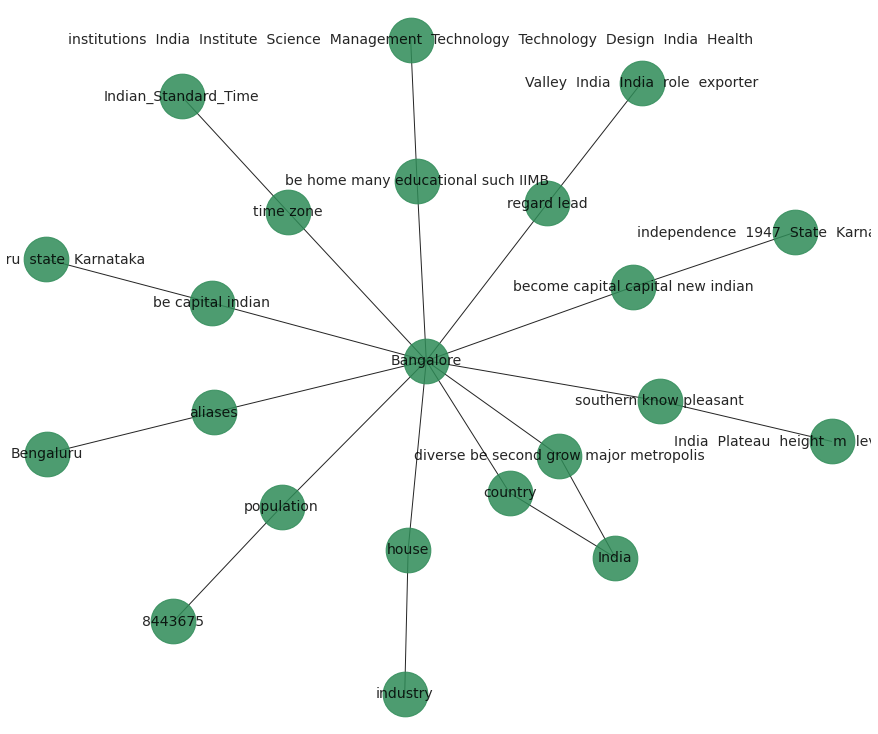

In [7]:
# convert the abstract to extract information and form triples 

sentences = getSentences(abstract)

triples = []
for sentence in sentences:
    triples.append(processSentence(sentence))

printGraph(triples)

### This is the final Knowledge Graph created using information extraction from city abstract text and a few  attributes like population and country queried from DBpedia. This is a basic implementation which can be improved by fine-tuning the 'relation' and 'object' nodes. 